In [151]:
# data processing
import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

# model
from sklearn.linear_model import LinearRegression

# metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PATH_TO_FILE = 'LR_insurance.csv'

In [32]:
df = pd.read_csv(PATH_TO_FILE)

In [33]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [35]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [36]:
smoker_label_encoder = LabelEncoder()
df['smoker'] = smoker_label_encoder.fit_transform(df['smoker'].values)

sex_label_encoder = LabelEncoder()
df['sex'] = sex_label_encoder.fit_transform(df['sex'].values)

In [37]:
sex_label_encoder.classes_

array(['female', 'male'], dtype=object)

In [38]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [39]:
# check the amount of males and females and their ratio
print(f'Males: {df[df["sex"]==1].size},\tFemales: {df[df["sex"]==0].size}')
print(f'Males/Females ratio = {df[df["sex"]==1].size / df[df["sex"]==0].size}')

Males: 4732,	Females: 4634
Males/Females ratio = 1.0211480362537764


We sea that the data is balanced in terms of sex

In [40]:
np.unique(df['region'])

array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)

<Axes: xlabel='region', ylabel='count'>

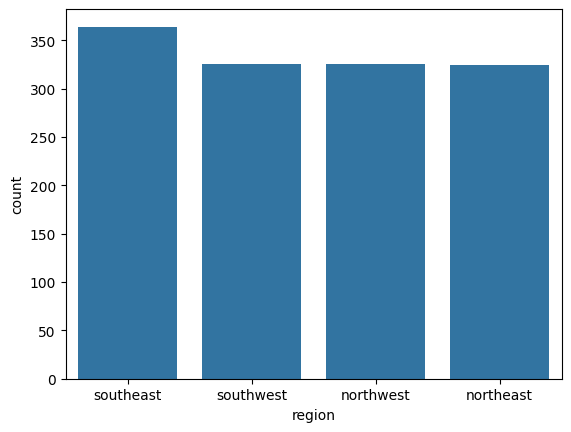

In [41]:
sns.barplot(df['region'].value_counts())

Regions types are balanced 

let's encode label 'region'

In [42]:
region_encoder = LabelEncoder()
df['region'] = region_encoder.fit_transform(df['region'])

In [43]:
region_encoder.classes_

array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)

let's look age destribution

<Axes: xlabel='age', ylabel='Count'>

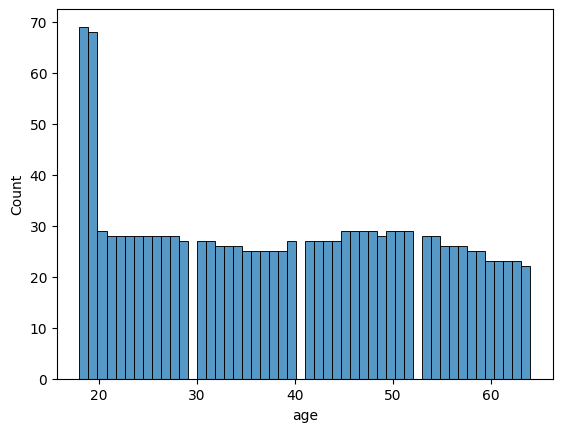

In [45]:
sns.histplot(df['age'], bins=50)

In [47]:
print(f'min age: {df["age"].min()}\tmax age: {df["age"].max()}')

min age: 18	max age: 64


<Axes: xlabel='bmi', ylabel='Count'>

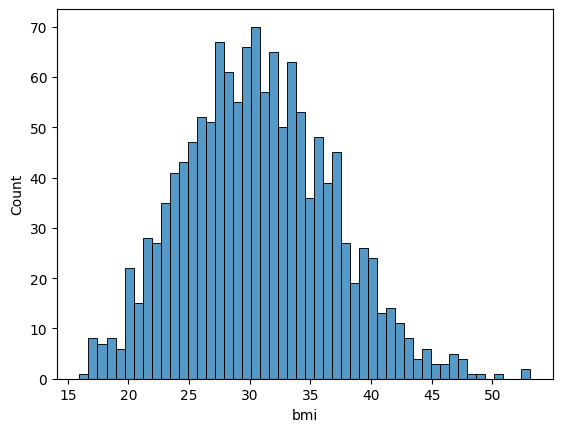

In [53]:
sns.histplot(df["bmi"], bins=50)

we have some outlayers in bmis

<Axes: xlabel='children', ylabel='count'>

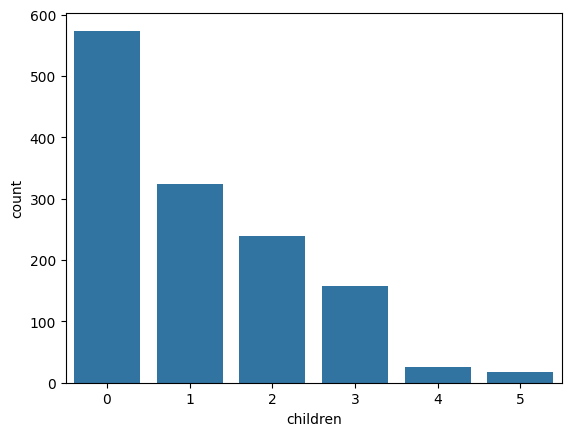

In [56]:
sns.barplot(df["children"].value_counts())

In [57]:
df["children"].value_counts()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

<Axes: xlabel='charges', ylabel='Count'>

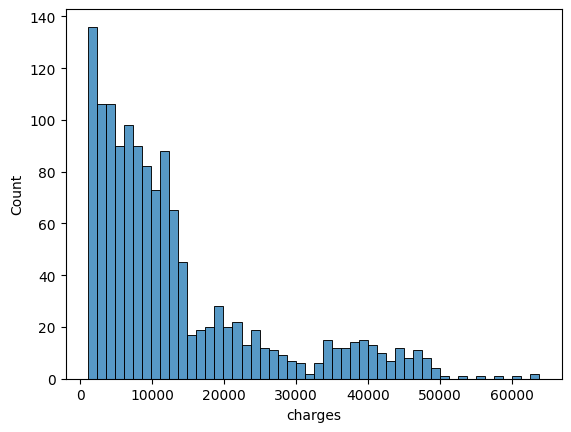

In [60]:
sns.histplot(df['charges'], bins=50)

In [70]:
print(f"samples with charges more than 50000: {df[df['charges']>50000].shape[0]}")

samples with charges more than 50000: 7


In [79]:
print(f'number of samples with bmi more than 50: {df[df["bmi"]>50].shape[0]}')

number of samples with bmi more than 50: 3


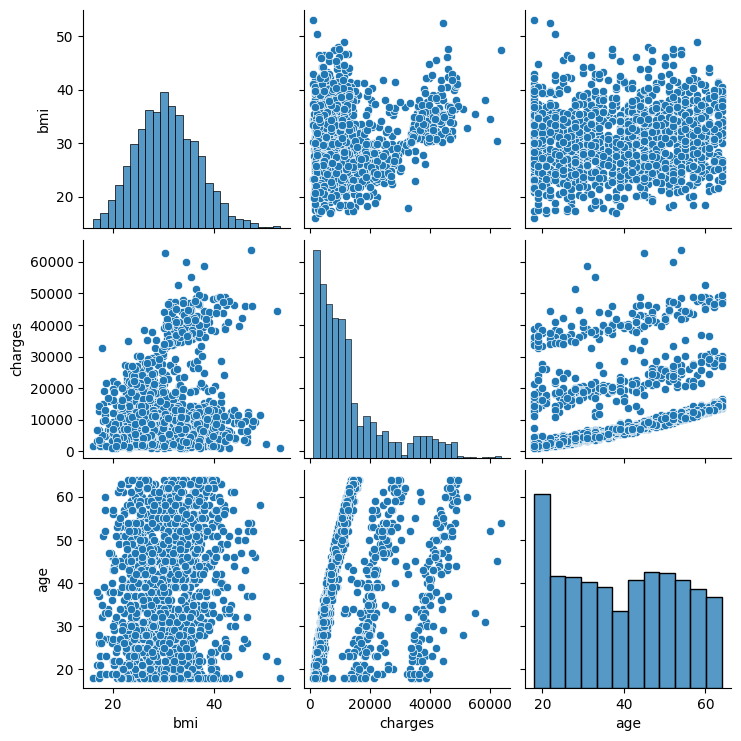

In [96]:
sns.pairplot(df[['bmi', 'charges', 'age']])

let's drop outlayers

In [80]:
bmi_outlayers = np.argsort(df["bmi"].values)[-3:]
charges_outlayers = np.argsort(df["charges"].values)[-7:]

In [94]:
indeces_to_drop = np.unique(bmi_outlayers.tolist() + charges_outlayers.tolist())
indeces_to_drop.sort()
indeces_to_drop.shape

(10,)

In [93]:
df.shape, df.drop(index=indeces_to_drop, axis=1).shape

((1338, 7), (1328, 7))

In [97]:
df.drop(index=indeces_to_drop, axis=1, inplace=True)

In [128]:
X, y = df[['age', 'bmi', 'children']].values, df['charges'].values
X_smoker = df[['age', 'bmi', 'children', 'smoker']].values

trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=20240415)
trainX_smoker, testX_smoker, trainY_smoker, testY_smoker = train_test_split(X_smoker, y, 
                                                                            test_size=0.2, random_state=20240415)

# Train a linear model

In [109]:
# min_max_scaler = MinMaxScaler()
# trainX_scaled = min_max_scaler.fit_transform(trainX)

In [121]:
ols = sm.OLS(trainY, sm.add_constant(trainX)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     47.39
Date:                Mon, 15 Apr 2024   Prob (F-statistic):           9.68e-29
Time:                        21:06:45   Log-Likelihood:                -11382.
No. Observations:                1062   AIC:                         2.277e+04
Df Residuals:                    1058   BIC:                         2.279e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5569.2366   1925.451     -2.892      0.004   -9347.373   -1791.100
x1           234.5614     24.006      9.771      0.000     187.456     281.667
x2           280.4421     56.571      4.957      0.000     169.439     391.446
x3           739.9716    282.559      2.619      0.009     185.532    1294.411
==============================================================================
Omnibus:                      248.482   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              443.961
Skew:                           1.506   Prob(JB):                     3.94e-97
Kurtosis:                       3.980   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
mse(trainY, ols.predict(sm.add_constant(trainX)))

119311557.92611481

Text(0, 0.5, 'age')

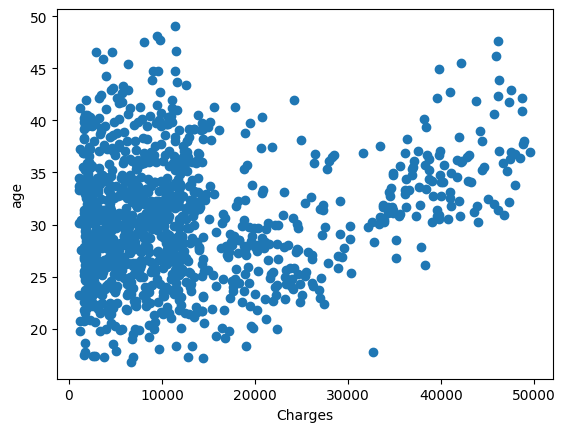

In [123]:
plt.scatter(trainY, trainX[:,1])
plt.xlabel('Charges')
plt.ylabel('age')

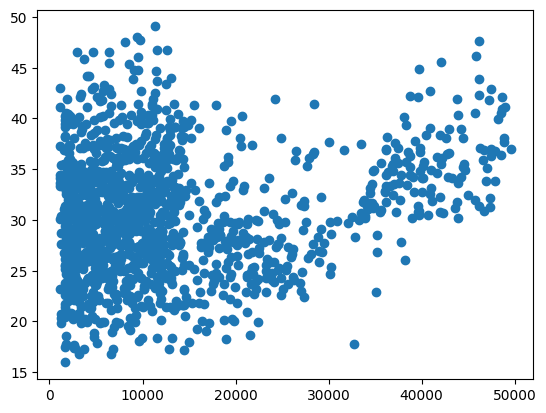

In [117]:
plt.scatter(df['charges'], df['bmi'].values)

In [129]:
ols_smoker = sm.OLS(trainY_smoker, sm.add_constant(trainX_smoker)).fit()
ols_smoker.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     783.1
Date:                Mon, 15 Apr 2024   Prob (F-statistic):          3.20e-314
Time:                        21:11:38   Log-Likelihood:                -10718.
No. Observations:                1062   AIC:                         2.145e+04
Df Residuals:                    1057   BIC:                         2.147e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.152e+04   1037.045    -11.105      0.000   -1.36e+04   -9481.749
x1           258.1208     12.857     20.076      0.000     232.893     283.349
x2           302.6516     30.281      9.995      0.000     243.233     362.070
x3           492.8468    151.310      3.257      0.001     195.945     789.749
x4          2.312e+04    450.228     51.344      0.000    2.22e+04     2.4e+04
==============================================================================
Omnibus:                      227.682   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              479.980
Skew:                           1.205   Prob(JB):                    5.94e-105
Kurtosis:                       5.244   Cond. No.                         296.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Наличие параметра smoker существенно улучшает качество модели

In [146]:
print(f'R^2 score: {r2_score(testY_smoker, ols_smoker.predict(sm.add_constant(testX_smoker)))}')
print(f'MSE score: {mse(testY_smoker, ols_smoker.predict(sm.add_constant(testX_smoker)))}')
print(f'MAPE score: {mape(testY_smoker, ols_smoker.predict(sm.add_constant(testX_smoker)))}')

R^2 score: 0.7650339604249398
MSE score: 32734579.79187856
MAPE score: 0.4051443410485606


## Permutation Importance

In [131]:
lr = LinearRegression()
lr.fit(trainX_smoker, trainY_smoker)
permut = permutation_importance(lr, trainX_smoker, trainY_smoker, n_repeats=100, random_state=20240415)

In [132]:
print(f'permutation mean: {permut.importances_mean}', f'permutation std: {permut.importances_std}', sep='\n')

permutation mean: [0.19477565 0.04863618 0.00507955 1.25850581]
permutation std: [0.01396756 0.00524106 0.00155022 0.04975984]


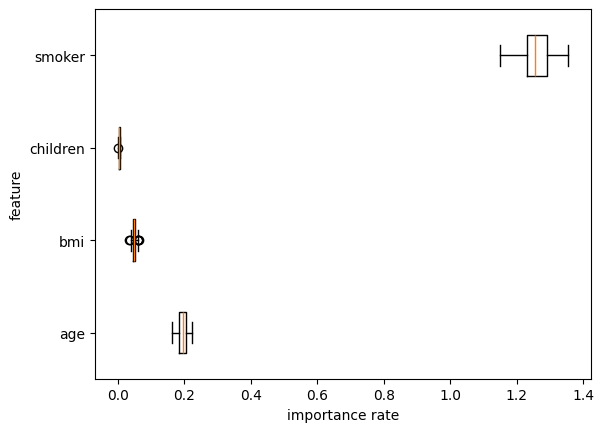

In [138]:
plt.boxplot(permut.importances.T, vert=False, labels=['age', 'bmi', 'children', 'smoker'])
plt.xlabel('importance rate')
plt.ylabel('feature')
plt.show()

In [140]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [141]:
lr = LinearRegression()
lr.fit(df[df.columns[:-1]].values, df[df.columns[-1]].values)

permut = permutation_importance(lr, df[df.columns[:-1]].values,
                                df[df.columns[-1]].values, 
                                n_repeats=100, random_state=20240415)

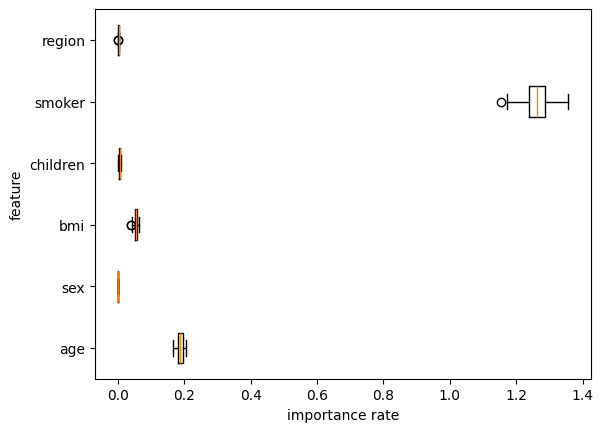

In [142]:
plt.boxplot(permut.importances.T, vert=False, labels=df.columns[:-1])
plt.xlabel('importance rate')
plt.ylabel('feature')
plt.show()

# Categorical features influence

In [152]:
def get_mse_categorical(df, features_in=None):
    columns = ['age', 'bmi']
    if features_in is not None:
        columns += features_in

    X, y = df[columns].values, df['charges'].values
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=20240415)

    lr = LinearRegression()
    lr.fit(trainX, trainY)
    mse_score = mse(testY, lr.predict(testX))
    return mse_score


In [153]:
mse_all_out = get_mse_categorical(df)
mse_no_out = get_mse_categorical(df, ['smoker', 'children', 'region', 'sex'])
mse_children = get_mse_categorical(df, ['children'])
mse_smoker = get_mse_categorical(df, ['smoker'])
mse_region = get_mse_categorical(df, ['region'])
mse_sex = get_mse_categorical(df, ['sex'])
mse_smoker_children = get_mse_categorical(df, ['smoker', 'children'])
mse_smoker_region = get_mse_categorical(df, ['smoker', 'region'])
mse_smoker_sex = get_mse_categorical(df, ['smoker', 'sex'])
mse_children_region = get_mse_categorical(df, ['children', 'region'])
mse_children_sex = get_mse_categorical(df, ['children', 'sex'])
mse_region_sex = get_mse_categorical(df, ['region', 'sex'])
mse_smoker_out = get_mse_categorical(df, ['children', 'region', 'sex'])
mse_children_out = get_mse_categorical(df, ['smoker', 'region', 'sex'])
mse_region_out = get_mse_categorical(df, ['smoker', 'children', 'sex'])
mse_sex_out = get_mse_categorical(df, ['smoker', 'children', 'region'])

In [164]:
mse_df = pd.DataFrame({'features': ['all out', 'no out', 'children',
                           'smoker', 'region', 'sex', 
                           'smoker_children', 'smoker_region',
                           'smoker_sex', 'children_region',
                           'children_sex', 'region_sex',
                           'smoker out', 'children out',
                           'region out', 'sex out'],
                        'features num': [0, 4, 1,
                                          1, 1, 1,
                                          2, 2, 2, 2,
                                          2, 2, 3, 3, 3, 3],
                        'mse': [mse_all_out, mse_no_out, mse_children,
                              mse_smoker, mse_region, mse_sex,
                              mse_smoker_children, mse_smoker_region, 
                              mse_smoker_sex, mse_children_region,
                              mse_children_sex, mse_region_sex, mse_smoker_out,
                              mse_children_out, mse_region_out, mse_sex_out]
                                    })

In [169]:
# mse_df.set_index('features', inplace=True)
mse_df.sort_values(by=['mse'])

,features,features num,mse
15,sex out,3,3.266022e+07
1,no out,4,3.270377e+07
6,smoker_children,2,3.273458e+07
14,region out,3,3.277379e+07
7,smoker_region,2,3.319962e+07
3,smoker,1,3.322690e+07
13,children out,3,3.324135e+07
8,smoker_sex,2,3.326412e+07
4,region,1,1.205726e+08
0,all out,0,1.206535e+08
